# Data Analytics with Spark

This work was produced by **MALLET Hugo, Gajendran Mithuran**


## Build a Spark Streaming application that shows popular hashtags on Twitter.
Goal : Write a Spark Streaming application that connects our Live Tweet Streaming application, extracts
hashtags, and displays the 10 most popular among them in the last 10 minutes.

In [1]:
import findspark
findspark.init('')
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
#Importing our spark context
sc = SparkContext.getOrCreate()
# we initiate the SQL StreamingContext with 10 second batch interval.
sql_stream_context = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [3]:
# initiate streaming text from a TCP (socket) source:
socket = sql_stream_context.socketTextStream("127.0.0.1", 5555)
# socket window of size 10 minutes : 60*10
tweetLines = socket.window(60*10)

# Processing tweets and saving them into a Table

In this part we will create an objet Tweet that will contain two fields : "Hashtag" and "Count". 
- Process tweets that we got from our the socket :
    - Split on space
    - Isolate the word starting by the "#"
    - Lower the hashtag that we got
    - Paring it as (key,value)    
- Store the counts corresponding to those hashtags into the Tweets table.
- Sort the table on count in descending mode so we can have the top ten easily
- Get the top_ten hashtags and register it using RegisterTempTable in a table named "top_tweets"

In [4]:
from collections import namedtuple
#Our fields : 
fields = ("hashtag", "count" )
# Tweet object allows us to save hastags with the count
Tweet = namedtuple( 'Tweet', fields )
# Operation on our tweets so we can store them

(tweetLines.flatMap( lambda line: line.split( " " ) ) #We split on space
# Looking for hashtags 
.filter( lambda word: word.lower().startswith("#") ) 
.map( lambda word: ( word.lower(), 1 ) )#Set to lower case
.reduceByKey( lambda a, b: a + b ) # As in Lab1 so we can count them
 #Storing it in our Tweet Object
.map( lambda tw: Tweet( tw[0], tw[1] ) )
# Sorting them in a Data Frame
.foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
# We only take into consideration the top 10 hashtags
.limit(10).registerTempTable("top_tweets") ))

In [5]:
sql_stream_context.start()

# Vizualisation : displays the 10 most popular among them in the last 10 minutes.
Finally we : 
- Requesting hashtags and count from our top_tweets table
- Setting it to Panda dataFrame so we can use Pandas' functionnalities
- Use Seaborn to vizualise it

Note : In our case, we chose to display tweets containing "Trump" in it as Tweepy doesn't provide a way to get all Tweets without any filter

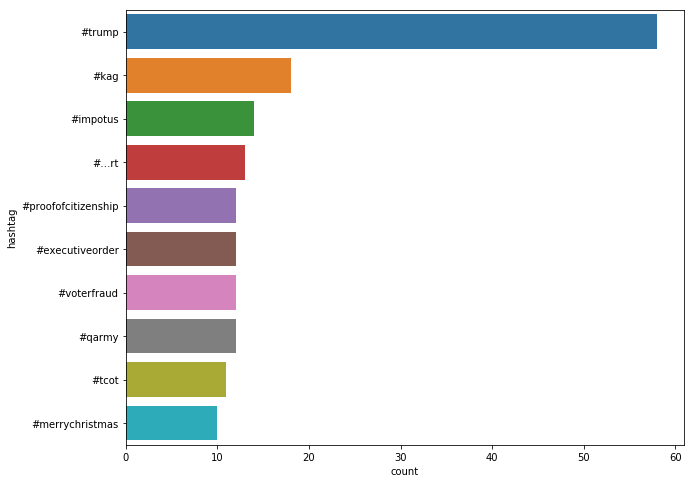

In [ ]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline
count = 0
while count < 50:
    time.sleep(5)
    top_hastags = sqlContext.sql( 'Select hashtag, count from top_tweets' ) #We request the hastags and counts from our table top_tweets
    top_10_hastags_dataframe = top_hastags.toPandas()
    display.clear_output(wait=True)
    #Plotting our figure
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_hastags_dataframe)
    plt.show()
    count = count + 1
print("done")

In [ ]:
sql_stream_context.stop()

According to our results when we launched our application, when the word "Trump" occurs in a tweet, the most popular hastaghs linked to it are :
   - #trump
   - #kag
   - #impotus
   - #....rt
   - #proofofcitizenship
   - #executiveorder
   - #voterfraud
   - #qarmy
   - #tcot
   - #merrychristmas